In [ ]:
from dotenv import load_dotenv
load_dotenv()

### **System message를 통한 더 나은 챗봇 구축**

In [1]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from datetime import datetime
from langchain_community.tools.tavily_search import TavilySearchResults

system_prompt = f"""
You are a helpful AI Assistant that can use web search tool(tavily ai api).
You should always answer in same language as user's ask.
When use ask about the information that you can't answer, you should call the web search tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guideline below:
- Extract the user query's intent and rephrase the prompt into appropriate search query
- web search tool(Tavily AI API) can deal with sentence query. 
you don't need to limit your querying ability to generating keyword only query.
- Today is {datetime.now().strftime("%Y-%m-%d")}
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])


# LLM 초기화 시 시스템 프롬프트 설정
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

search = TavilySearchResults(max_results=5)

tools = [search]
llm_with_tools = llm.bind_tools(tools)

# 프롬프트 체인 생성
chain = prompt | llm_with_tools

result = chain.invoke({"input": "대한민국 축구국가대표팀 명단 알려줘"})
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_RpbEj13SN68fIHuqaEOGyJN3', 'function': {'arguments': '{"query":"대한민국 축구 국가대표팀 2025 명단"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 232, 'total_tokens': 262, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BL7y02FrZ7atPch66OdJd5IHNT2FM', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-be829a5e-1210-43e5-881e-e706139f9ab3-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '대한민국 축구 국가대표팀 2025 명단'}, 'id': 'call_RpbEj13SN68fIHuqaEOGyJN3', 'type': 'tool_call'}] usage_metadata={'input_tokens': 232, 'output_tokens': 30, 'total_tokens': 262, 'input

In [2]:
print(result.additional_kwargs)

{'tool_calls': [{'id': 'call_RpbEj13SN68fIHuqaEOGyJN3', 'function': {'arguments': '{"query":"대한민국 축구 국가대표팀 2025 명단"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}


In [3]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# 도구 호출 후 채팅봇으로 돌아가는 엣지 추가
graph_builder.add_edge("tools", "chatbot")

# 시작점 설정
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

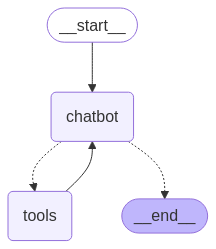

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# The config is the **second positional argument** to stream() or invoke()!
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today?


### **Custom tool 설정을 통한 도구 통제성 향상**

In [8]:
from dotenv import load_dotenv
load_dotenv()

False

In [10]:
from langchain_core.tools import tool
from tavily import TavilyClient

@tool
def search_news(keyword: str) -> str:
    """Collect recent news for the given query. """
    tavily_client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
    search_results = tavily_client.search(query=keyword, topic="news", days = 30)
    return search_results

In [11]:
# LLM 초기화 시 시스템 프롬프트 설정
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

tools = [search_news]
llm_with_tools = llm.bind_tools(tools)

In [12]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# 도구 호출 후 채팅봇으로 돌아가는 엣지 추가
graph_builder.add_edge("tools", "chatbot")

# 시작점 설정
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

In [13]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today?
